## Install requirements
This Notebook can find frames of video with a given desctiption. The Notebook code is based on the  [YiYiXiu It Happened One Frame](https://yiyixuxu.github.io/2022/06/12/It-Happened-One-Frame.html) work, using [CLIP OpenAI](https://openai.com/blog/clip/) library. CLIP model trained byu OpenAI use a transformer architecture to match an image with a caption. Using multimodal neurons capable to activate when the stimuli comes eother form an image or a text. You can read more about the research work [here](https://openai.com/blog/clip/)

In [5]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lYxC94CQkFGeBAp7xd8ZMs1O8Hd5kky6' -O requirements.txt

--2022-06-15 22:51:40--  https://docs.google.com/uc?export=download&id=1lYxC94CQkFGeBAp7xd8ZMs1O8Hd5kky6
Resolving docs.google.com (docs.google.com)... 142.250.128.102, 142.250.128.101, 142.250.128.100, ...
Connecting to docs.google.com (docs.google.com)|142.250.128.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-40-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h1rbfig39ukj6h23nkpf6bos033p90im/1655333475000/08751577083393910104/*/1lYxC94CQkFGeBAp7xd8ZMs1O8Hd5kky6?e=download [following]
--2022-06-15 22:51:41--  https://doc-0g-40-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h1rbfig39ukj6h23nkpf6bos033p90im/1655333475000/08751577083393910104/*/1lYxC94CQkFGeBAp7xd8ZMs1O8Hd5kky6?e=download
Resolving doc-0g-40-docs.googleusercontent.com (doc-0g-40-docs.googleusercontent.com)... 108.177.120.132, 2607:f8b0:4001:c18::84
Connecting to doc-0g-40-docs.googleusercontent.com (doc-0g-40-docs

In [6]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-9n9z0i4c
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-9n9z0i4c


In [7]:
!pip show opencv-python

Name: opencv-python
Version: 4.6.0.66
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/skvark/opencv-python
Author: None
Author-email: None
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy
Required-by: imgaug, dopamine-rl, albumentations


# Import libraries
The Notebook is based on the [YiYiXiu](https://yiyixuxu.github.io/2022/06/12/It-Happened-One-Frame.html) work, using [CLIP OpenAI](https://openai.com/blog/clip/) library

In [8]:
import os
import cv2
import clip
import torch
import shutil
import datetime
import youtube_dl
import numpy as np
from pathlib import Path
from functools import partial
import matplotlib.pyplot as plt
from multiprocessing.pool import Pool
from PIL import Image,ImageDraw, ImageFont

100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 97.5MiB/s]


## Create Video Extractor
This class downloads a video from youtube and extract the frames in a sampling interval

In [10]:
class VideoExtractor:

  def __init__(self):
    self.detault_resolutions = ['480p', '360p','240p','144p']
  
  # Parse video format
  def get_video_format(self, url, ydl_opts={}, format_note='240p', ext='mp4', max_size = 500000000):
    ydl = youtube_dl.YoutubeDL(ydl_opts)
    info_dict = ydl.extract_info(url, download=False)
    formats = info_dict.get('formats', None)
    # filter out formats we can't process
    formats = [f for f in formats if f['ext'] == ext 
               and f['vcodec'].split('.')[0] != 'av01' 
               and f['filesize'] is not None and f['filesize'] <= max_size]
    available_format_notes = set([f['format_note'] for f in formats])
    
    if format_note not in available_format_notes:
      format_note = [d for d in self.default_resolutions if d in available_format_notes][0]
    formats = [f for f in formats if f['format_note'] == format_note]
    format = formats[0]
    format_id = format.get('format_id', None)
    fps = format.get('fps', None)
    print(f'format selected: {format}')
    return(format, format_id, fps)
  
  #Download video from youtube
  def download_video(self, url):
    # create "videos" foder for saved videos
    path_videos = Path('videos')
    try:
      path_videos.mkdir(parents=True)
    except FileExistsError:
      pass
    # clear the "videos" folder 
    videos_to_keep = ['v1rkzUIL8oc', 'k4R5wZs8cxI','0diCvgWv_ng']
    if len(list(path_videos.glob('*'))) > 10:
        for path_video in path_videos.glob('*'):
            if path_video.stem not in set(videos_to_keep):
                path_video.unlink()
                print(f'removed video {path_video}')
    # select format to download for given video
    try:
      format, format_id, fps = self.get_video_format(url)
      ydl_opts = {
        'format':format_id,
        'outtmpl': "videos/%(id)s.%(ext)s"}

      with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        try:
          ydl.cache.remove()
          meta = ydl.extract_info(url)
          save_location = 'videos/' + meta['id'] + '.' + meta['ext']
        except youtube_dl.DownloadError as error:
          print(f'error with download_video function: {error}')
          save_location = None
    except IndexError as err:
      print(f"can't find suitable video formats. we are not able to process video larger than 95 Mib at the moment")
      fps, save_location = None, None
    return(fps, save_location)

  # Extract frames for video 
  def extract_frames_from_video(self, video, skip_frames, dest_path, num_processes, process_number):
    cap = cv2.VideoCapture(video)
    frames_per_process = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) // (num_processes)
    count =  frames_per_process * process_number
    cap.set(cv2.CAP_PROP_POS_FRAMES, count)
    print(f"worker: {process_number}, process frames {count} ~ {frames_per_process * (process_number + 1)} \n total number of frames: {cap.get(cv2.CAP_PROP_FRAME_COUNT)} \n video: {video}; isOpen? : {cap.isOpened()}")
    while count < frames_per_process * (process_number + 1) :
        ret, frame = cap.read()
        if not ret:
            break
        if count  % skip_frames ==0:
          filename =f"{dest_path}/{count}.jpg"
          cv2.imwrite(filename, frame)
        count += 1
    cap.release()
  
  # Extract images from video frames using the sampling interval
  def video_to_frames(self, url, sampling_interval=1):
    # create folder for extracted frames - if folder exists, delete and create a new one
    path_frames = Path('frames')
    try:
        path_frames.mkdir(parents=True)
    except FileExistsError:
        shutil.rmtree(path_frames)
        path_frames.mkdir(parents=True)
 
    # download the video 
    fps, video = self.download_video(url)
    if video is not None: 
      if fps is None: fps = 30
      skip_frames = int(fps * sampling_interval)
      print(f'video saved at: {video}, fps:{fps}, skip_frames: {skip_frames}')
      # extract video frames at given sampling interval with multiprocessing - 
      n_workers = min(os.cpu_count(), 12)
      print(f'now extracting frames with {n_workers} process...')

      with Pool(n_workers) as pool:
        pool.map(partial(self.extract_frames_from_video, video, skip_frames, path_frames, n_workers), range(n_workers))
    else:
      skip_frames, path_frames = None, None
    return (skip_frames, path_frames)
    
  


## Run inference 
This class check similarity of a text query from a folder of images

In [25]:
class SearchImages:

  def __init__(self, threshold = 0.7):
    self.threshold = threshold
    self.device = "cuda" if torch.cuda.is_available() else "cpu"
    self.model, self.preprocess = clip.load("ViT-B/32")

  def folder_inference(self, folder_path, query, batch_size=526, threshold=None):
    matches = []
    threshold = threshold if threshold else self.threshold
    filenames = sorted(Path(folder_path).glob('*.jpg'),key=lambda p: int(p.stem))
    n_images = len(filenames)
    batch_size = min(n_images,batch_size)
    print(f"processing {n_images}, now encoding images")
    # encoding images one batch at a time, combine all batch outputs -> image_features, size n_frames x 512
    image_features = torch.empty(size=(n_images, 512),dtype=torch.float32).to(self.device)
    print(f"encoding images, batch size :{batch_size} ; number of batches: {len(range(0, n_images,batch_size))}")
    for b in range(0, n_images,batch_size):
      images = []
      # loop through all frames in the batch -> create batch_image_input, size bs x 3 x 224 x 224
      for filename in filenames[b:b+batch_size]:
        image = Image.open(filename).convert("RGB")
        images.append(self.preprocess(image))
      batch_image_input = torch.tensor(np.stack(images)).to(self.device)
      # encoding batch_image_input -> batch_image_features
      with torch.no_grad():
        batch_image_features = self.model.encode_image(batch_image_input)
        batch_image_features /= batch_image_features.norm(dim=-1, keepdim=True)
      #add encoded image embedding to image_features
      image_features[b:b+batch_size] = batch_image_features
    #encoding search query
    print(f'encoding search query')
    with torch.no_grad():
      text_features = self.model.encode_text(clip.tokenize(query).to(self.device)).to(dtype=torch.float32)
      text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (image_features @ text_features.T)
    for i in range(similarity.shape[0]):
      if similarity[i][0] >= threshold:
        matches.append((filenames[i], similarity[i][0]))
    return matches

  def show_results(self, matches, show_images = True):
    print(f"{len(matches)} results...")
    for match in matches:
      print(match[1])
      if show_images:
        match = Image.open(match[0]).convert("RGB")
        plt.imshow(match)
        plt.show()

## Putting all togehter: Download video

In [11]:
url = 'https://www.youtube.com/watch?v=hr3venGkt04'
video_extractor = VideoExtractor()
(skip_frames, path_frames) = video_extractor.video_to_frames(url)

[youtube] hr3venGkt04: Downloading webpage
format selected: {'asr': None, 'filesize': 290748, 'format_id': '133', 'format_note': '240p', 'fps': 18, 'height': 240, 'quality': 1, 'tbr': 231.579, 'url': 'https://rr4---sn-qxoednee.googlevideo.com/videoplayback?expire=1655357304&ei=GGuqYrSHF8HGuALWjogI&ip=34.123.205.121&id=o-APqjQ-P5n4cxo38hWridN2MZ5PMg5EVLbZXHuSWskVs3&itag=133&aitags=133%2C134%2C135%2C136%2C160%2C242%2C243%2C244%2C247%2C278&source=youtube&requiressl=yes&mh=Ee&mm=31%2C26&mn=sn-qxoednee%2Csn-5goeenes&ms=au%2Conr&mv=u&mvi=4&pl=20&spc=4ocVCwp7VUgXAQ8OocH8vNIFHd_Tfjo&vprv=1&mime=video%2Fmp4&ns=Nt4npnyZeGBw5r4gdtgEFuwG&gir=yes&clen=290748&dur=10.044&lmt=1632700762567413&mt=1655335016&fvip=5&keepalive=yes&fexp=24001373%2C24007246&c=WEB&txp=5316224&n=QrZWJxNdZIEUqKyqObX&sparams=expire%2Cei%2Cip%2Cid%2Caitags%2Csource%2Crequiressl%2Cspc%2Cvprv%2Cmime%2Cns%2Cgir%2Cclen%2Cdur%2Clmt&sig=AOq0QJ8wRQIhAMSk6ca4DywNvPZjUDtneOZDP6DU9XPyOAr1l9MK8GvPAiAuP3cPh3TpY8H9RIbKd61ho9vcJ7yGnT2dLE1zKnC

## Find images

In [23]:
folder_path = 'frames'
query = 'A jaguar'
finder = SearchImages()
matches = finder.folder_inference(folder_path, query, 526, 0.2)

processing 11, now encoding images
encoding images, batch size :11 ; number of batches: 1
encoding search query


10 results...
tensor(0.2819, device='cuda:0')


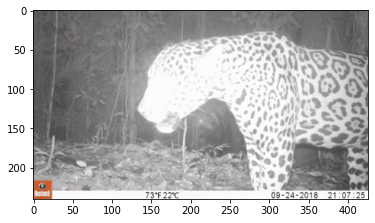

tensor(0.2895, device='cuda:0')


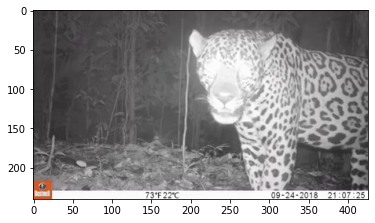

tensor(0.2855, device='cuda:0')


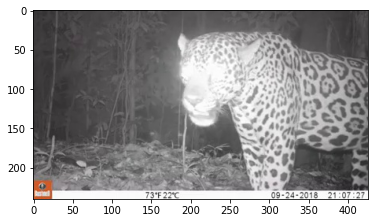

tensor(0.2938, device='cuda:0')


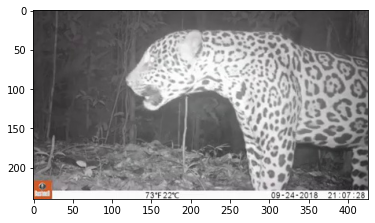

tensor(0.2760, device='cuda:0')


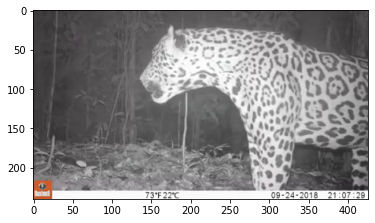

tensor(0.2717, device='cuda:0')


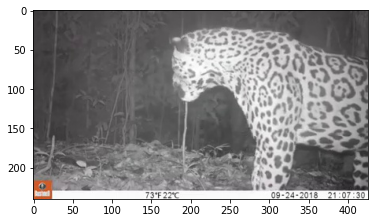

tensor(0.2772, device='cuda:0')


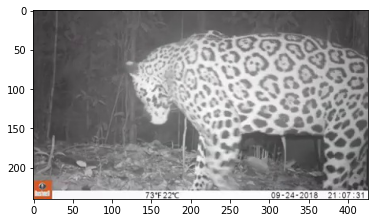

tensor(0.2700, device='cuda:0')


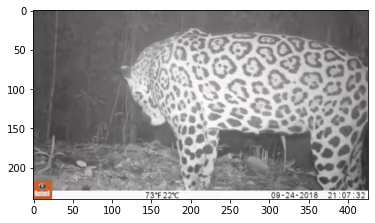

tensor(0.2780, device='cuda:0')


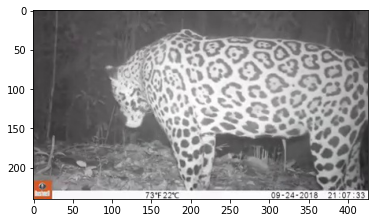

tensor(0.2825, device='cuda:0')


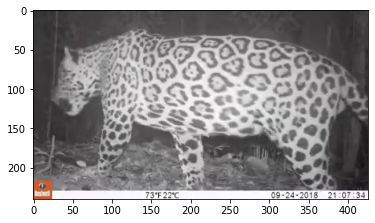

In [24]:
finder.show_results(matches)

processing 11, now encoding images
encoding images, batch size :11 ; number of batches: 1
encoding search query
3 results...
tensor(0.2792, device='cuda:0')


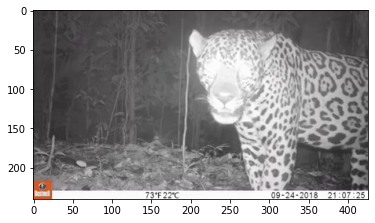

tensor(0.2825, device='cuda:0')


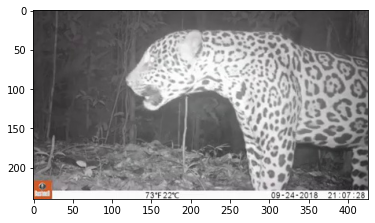

tensor(0.2723, device='cuda:0')


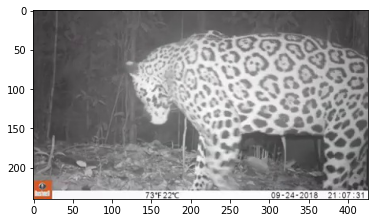

In [26]:
folder_path = 'frames'
query = 'A jaguar profile'
matches = finder.folder_inference(folder_path, query, 526, 0.27)
finder.show_results(matches)

processing 11, now encoding images
encoding images, batch size :11 ; number of batches: 1
encoding search query
1 results...
tensor(0.2202, device='cuda:0')


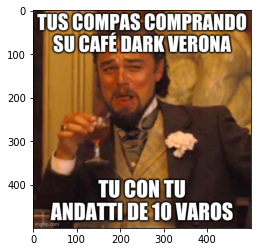

In [28]:
folder_path = 'frames'
query = 'A person with a glass'
matches = finder.folder_inference(folder_path, query, 526, 0.20)
finder.show_results(matches)